In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# rcParams background color
plt.rcParams['figure.facecolor'] = 'white'

%matplotlib inline

In [4]:
# Read in the unseen file
df_unseen = pd.read_csv(r'C:\Users\user\Downloads\df_unseen.csv')
df_unseen.head()

,finishing_position,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,...,running_position_6,race_id,recent_6_runs,recent_ave_rank,race_distance,HorseWin,HorseRankTop3,HorseRankTop50Percent,jockey_ave_rank,trainer_ave_rank
0,1,8.0,PRINCE HARMONY,V012,D Whyte,W Y So,119,1142,2,-,...,NaN,2016-564,1/13/9/6/10,7.800000,1200,1,1,1,5.795734,7.117705
1,2,2.0,GRACYDAD,V200,Z Purton,D J Hall,133,1092,7,SH,...,NaN,2016-564,2/1/6/3/3/3,6.352941,1200,0,1,1,5.343498,6.639836
2,3,7.0,SUNNY ORIENT,V302,N Rawiller,A T Millard,125,1071,6,1,...,NaN,2016-564,3/7/14/8/6/14,8.900000,1200,0,1,1,6.436170,6.722508
3,4,3.0,CAREFREE LET GO,T059,H T Mo,C S Shum,116,1063,3,1,...,NaN,2016-564,4/7/6/5/9/3,5.541667,1200,0,0,1,8.040000,6.631579
4,5,11.0,KWAICHUNG BROTHERS,A012,C Schofield,R Gibson,115,1139,1,4-1/2,...,NaN,2016-564,5/3/5/8/12/11,7.857143,1200,0,0,1,6.621572,6.628536


In [5]:
df_unseen.columns

Index(['finishing_position', 'horse_number', 'horse_name', 'horse_id',
       'jockey', 'trainer', 'actual_weight', 'declared_horse_weight', 'draw',
       'length_behind_winner', 'running_position_1', 'running_position_2',
       'running_position_3', 'running_position_4', 'finish_time', 'win_odds',
       'running_position_5', 'running_position_6', 'race_id', 'recent_6_runs',
       'recent_ave_rank', 'race_distance', 'HorseWin', 'HorseRankTop3',
       'HorseRankTop50Percent', 'jockey_ave_rank', 'trainer_ave_rank'],
      dtype='object')

In [11]:
# Read in our 4 classification predictions
lr_pred = pd.read_csv(r'C:\Users\user\Downloads\lr_pred.csv')
gnb_pred = pd.read_csv(r'C:\Users\user\Downloads\gnb_pred.csv')
rfc_pred = pd.read_csv(r'C:\Users\user\Downloads\rfc_pred.csv')
smote_rfc_pred = pd.read_csv(r'C:\Users\user\Downloads\smote_rfc_pred.csv')

In [12]:
# Read in our 4 regression predictions
ridge_pred = pd.read_csv(r'C:\Users\user\Downloads\ridge_pred.csv')
knn_pred = pd.read_csv(r'C:\Users\user\Downloads\knn_pred.csv')
rf_pred = pd.read_csv(r'C:\Users\user\Downloads\rf_pred.csv')
lgbm_pred = pd.read_csv(r'C:\Users\user\Downloads\lgbm_pred.csv')

In [13]:
df_unseen['win_odds'].sort_values(ascending=True).index[0]

2026

In [14]:
# Check on baseline case where we just bet on the horse with the lowest odds
# Test on the df_unseen dataframes

def buy_lowest_odds(df, best_odds, graph=True):

    money=0
    bets_made=[]
    cumulative_money=[]

    for race_id in df['race_id'].unique():
        # Make a temporary dataframe
        df_temp = df[df['race_id'] == race_id]

        # Find the index with the lowest odds
        idx = df_temp['win_odds'].sort_values(ascending=True)[:best_odds].index

        bet_counter=0

        for i in idx:
            # If the horse wins, add the win_odds to the money
            if df_temp['finishing_position'][i] == 1:
                money += (df_temp['win_odds'][i] - 1)
                bet_counter += 1
                cumulative_money.append(money)
            else:
                money += -1
                bet_counter += 1
                cumulative_money.append(money)

        bets_made.append(bet_counter)    

    if graph==True: 
        # Plot the cumulative money
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_money)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.title('Cumulative Money for Every $1 Bet')
        plt.xlabel('Bets Made')
        plt.ylabel('Cumulative Money')
        plt.show()

        # Plot the bets made
        plt.figure(figsize=(10, 6))
        plt.plot(bets_made)
        plt.title('Total Bets Made')
        plt.show()
        
    # Print the final money and bets made
    print('Final Money made from Baseline: ', round(money,3))
    print('Total Bets Made: ', round(sum(bets_made),3))

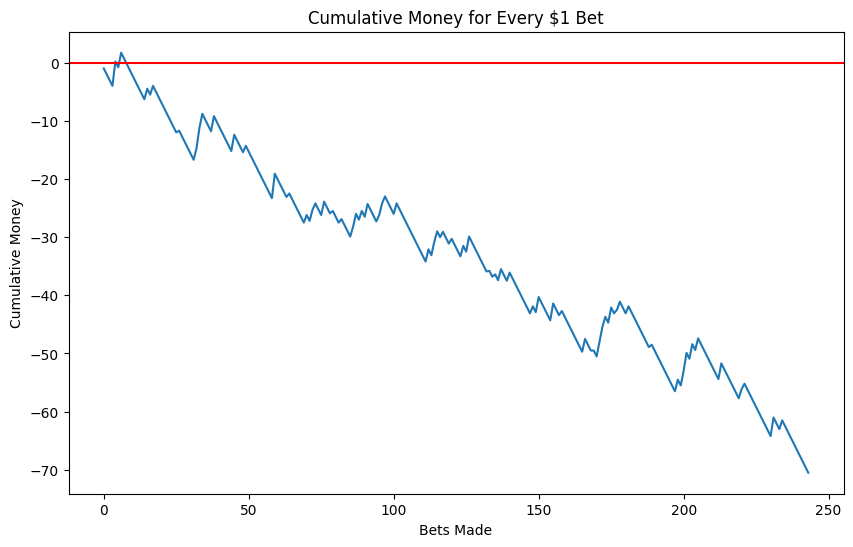

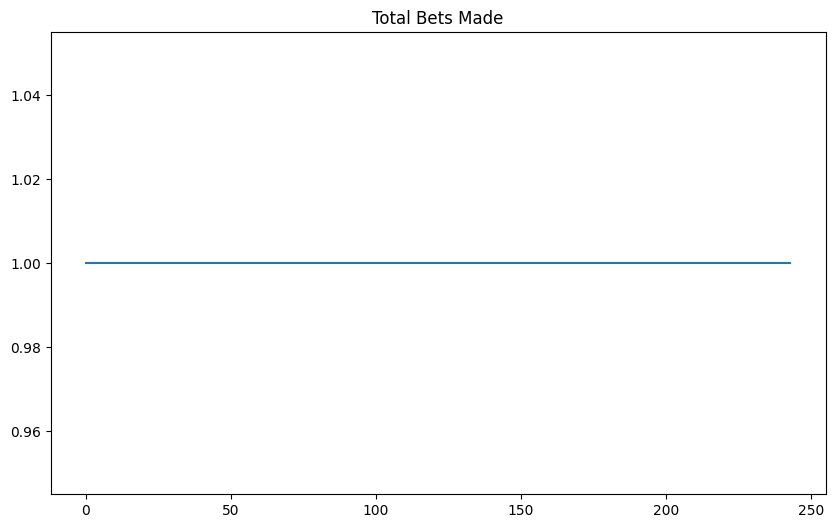

Final Money made from Baseline:  -70.5
Total Bets Made:  244


In [15]:
buy_lowest_odds(df_unseen, 1, True)

In [16]:
buy_lowest_odds(df_unseen, 3, False)

Final Money made from Baseline:  -31.3
Total Bets Made:  732


In [17]:
# Define a function to backtest the betting strategy
def simple_class_strategy(model_pred, graph=True):

    df_unseen_results = df_unseen[['finishing_position', 'win_odds', 'race_id', 
                               'HorseWin', 'horse_id']]

    # rename columns
    df_unseen_results = df_unseen_results.rename(columns={'race_id': 'RaceID', 
                                                    'horse_id': 'HorseID', 
                                                    'HorseWin':'ActualWin'})
    
    # merge the prediction with the test data
    df_backtest = pd.merge(model_pred, df_unseen_results, on=('RaceID', 'HorseID'), how='left')

    money = 0
    bets_made = []
    cumulative_money = [0]

    for race_id in df_backtest['RaceID'].unique():

        # make a temporary dataframe one for that particular race
        temp_df = df_backtest[df_backtest['RaceID']==race_id]

        # find out the bets we made
        bets = temp_df[temp_df['HorseWin']==1]

        # deduct money for bets we made
        deduction  = -len(bets)

        # amount won from bets
        # sum of multiplying the odds with the prediction
        amount_won = sum(bets['win_odds']*bets['ActualWin'])
        
        # add the amount won to the money
        money += (amount_won + deduction)

        # append the money to the cumulative money list
        cumulative_money.append(money)

        # append the bets made to the bets made list
        bets_made.append(len(bets))
    
    if graph==True:
        # plot the cumulative money
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_money)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.title('Cumulative Money for Every $1 Bet')
        plt.xlabel('Bets Made')
        plt.ylabel('Cumulative Money')
        plt.show()

        # plot the bets made
        plt.figure(figsize=(10, 6))
        plt.plot(bets_made)
        plt.title('Bets Made')
        plt.show()

    # print the final money and bets made
    print('Final Money: ', round(money, 3))
    print('Total Bets Made: ', round(sum(bets_made),3), '\n')

    return money, bets_made

In [18]:
# define regression backtest function
def simple_reg_strategy(model_pred, graph=True):
        
        df_unseen_results = df_unseen[['finishing_position', 'win_odds', 'race_id', 'HorseWin', 'horse_id']]

        # rename columns
        df_unseen_results = df_unseen_results.rename(columns={'race_id': 'RaceID', 
                                                        'horse_id': 'HorseID', 
                                                        'HorseWin':'ActualWin'})
        
        # merge the prediction with the test data
        df_unseen_results['pred_time'] = model_pred['0']

        money = 0
        bets_made = []
        cumulative_money = [0]

        for race_id in df_unseen_results['RaceID'].unique():

                # make a temporary dataframe one for that particular race
                temp_df = df_unseen_results[df_unseen_results['RaceID']==race_id]

                # bet only on the horse with the fastest time
                # return dataframe where the time is the minimum
                bets = temp_df[temp_df['pred_time']==temp_df['pred_time'].min()]

                # deduct money for bets we made
                deduction  = -len(bets)

                # amount won from bets
                # sum of multiplying the odds with the prediction
                amount_won = sum(bets['win_odds']*bets['ActualWin'])
                
                # add the amount won to the money
                money += (amount_won + deduction)

                # append the money to the cumulative money list
                cumulative_money.append(money)

                # append the bets made to the bets made list
                bets_made.append(len(bets))
        
        if graph==True:
                # plot the cumulative money
                plt.figure(figsize=(10, 6))
                plt.plot(cumulative_money)
                plt.axhline(y=0, color='r', linestyle='-')
                plt.title('Cumulative Money for Every $1 Bet')
                plt.xlabel('Bets Made')
                plt.ylabel('Cumulative Money')
                plt.show()

                # plot the bets made
                plt.figure(figsize=(10, 6))
                plt.plot(bets_made)
                plt.title('Bets Made')
                plt.show()

        # print the final money and bets made
        print('Final Money: ', round(money, 3))
        print('Total Bets Made: ', round(sum(bets_made),3), '\n')

        return money, bets_made
                

In [19]:
# Define a function to backtest the betting strategy
def top3_strategy(model_pred, graph=True):

    df_unseen_results = df_unseen[['finishing_position', 'win_odds', 'race_id', 
                               'HorseWin', 'horse_id']]

    # rename columns
    df_unseen_results = df_unseen_results.rename(columns={'race_id': 'RaceID', 
                                                    'horse_id': 'HorseID', 
                                                    'HorseWin':'ActualWin'})
    
    # merge the prediction with the test data
    df_backtest = pd.merge(model_pred, df_unseen_results, on=('RaceID', 'HorseID'), how='left')

    money = 0
    bets_made = []
    cumulative_money = [0]

    for race_id in df_backtest['RaceID'].unique():

        # make a temporary dataframe one for that particular race
        temp_df = df_backtest[df_backtest['RaceID']==race_id]

        # find out the bets we made
        bets = temp_df[temp_df['HorseRankTop3']==1]

        # deduct money for bets we made
        deduction  = -len(bets)

        # amount won from bets
        # sum of multiplying the odds with the prediction
        amount_won = sum(bets['win_odds']*bets['ActualWin'])
        
        # add the amount won to the money
        money += (amount_won + deduction)

        # append the money to the cumulative money list
        cumulative_money.append(money)

        # append the bets made to the bets made list
        bets_made.append(len(bets))
    
    if graph==True:
        # plot the cumulative money
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_money)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.title('Cumulative Money for Every $1 Bet')
        plt.xlabel('Bets Made')
        plt.ylabel('Cumulative Money')
        plt.show()

        # plot the bets made
        plt.figure(figsize=(10, 6))
        plt.plot(bets_made)
        plt.title('Bets Made')
        plt.show()

    # print the final money and bets made
    print('Final Money: ', round(money, 3))
    print('Total Bets Made: ', round(sum(bets_made),3), '\n')

    return money, bets_made

In [20]:
# Define a function to backtest the betting strategy
def hybrid_strategy(class_pred, reg_pred, graph=True):

    df_unseen_results = df_unseen[['finishing_position', 'win_odds', 'race_id', 
                               'HorseWin', 'horse_id']]

    # rename columns
    df_unseen_results = df_unseen_results.rename(columns={'race_id': 'RaceID', 
                                                    'horse_id': 'HorseID', 
                                                    'HorseWin':'ActualWin'})
    
    # merge the prediction with the test data
    df_hybrid = pd.merge(class_pred, df_unseen_results, on=('RaceID', 'HorseID'), how='left')
    df_hybrid['pred_time'] = reg_pred['0']

    money = 0
    bets_made = []
    cumulative_money = [0]

    for race_id in df_hybrid['RaceID'].unique():

        # make a temporary dataframe one for that particular race
        temp_df = df_hybrid[df_hybrid['RaceID']==race_id]

        # find out the bets we made
        top_filter = temp_df['HorseWin']==1
        top3_filter = temp_df['HorseRankTop3']==1
        time_filter = temp_df['pred_time']==temp_df['pred_time'].min()

        bets = temp_df[(top_filter) & (top3_filter) & (time_filter)]

        # deduct money for bets we made
        deduction  = -len(bets)

        # amount won from bets
        # sum of multiplying the odds with the prediction
        amount_won = sum(bets['win_odds']*bets['ActualWin'])
        
        # add the amount won to the money
        money += (amount_won + deduction)

        # append the money to the cumulative money list
        cumulative_money.append(money)

        # append the bets made to the bets made list
        bets_made.append(len(bets))
    
    if graph==True:
        # plot the cumulative money
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_money)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.title('Cumulative Money for Every $1 Bet')
        plt.xlabel('Bets Made')
        plt.ylabel('Cumulative Money')
        plt.show()

        # plot the bets made
        plt.figure(figsize=(10, 6))
        plt.plot(bets_made)
        plt.title('Bets Made')
        plt.show()

    # print the final money and bets made
    print('Final Money: ', round(money, 3))
    print('Total Bets Made: ', round(sum(bets_made),3), '\n')

    return money, bets_made

In [21]:
class_pred_dict = {'Logistic Regression': lr_pred, 
                    'Gaussian Naive Bayes': gnb_pred,
                    'Random Forest Classifier': rfc_pred,
                    'SMOTE + RF': smote_rfc_pred}

reg_pred_dict = {'Ridge Regression': ridge_pred,
                'KNN Regression': knn_pred,
                'Random Forest Regressor': rf_pred,
                'LGBM': lgbm_pred}

Logistic Regression


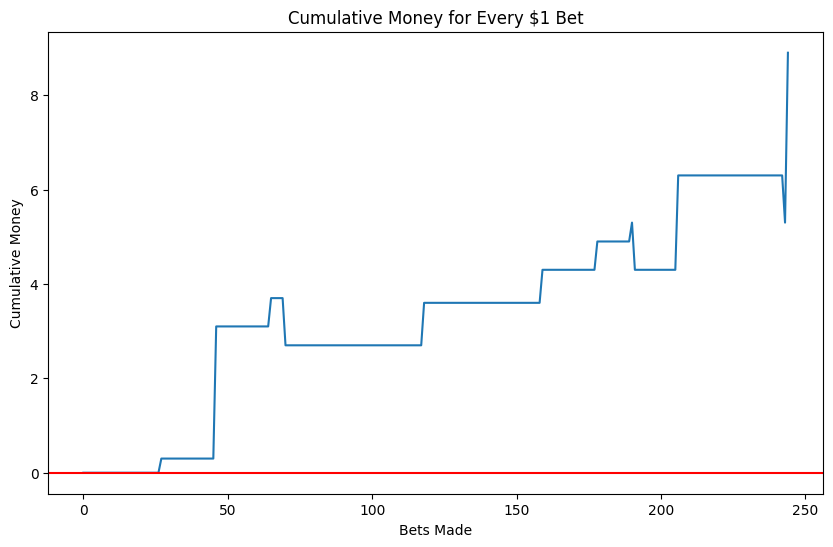

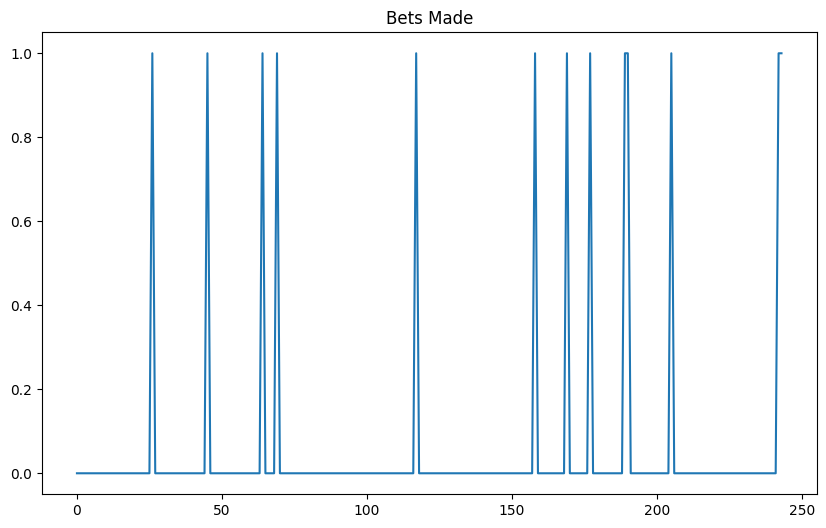

Final Money:  8.9
Total Bets Made:  13 

Gaussian Naive Bayes


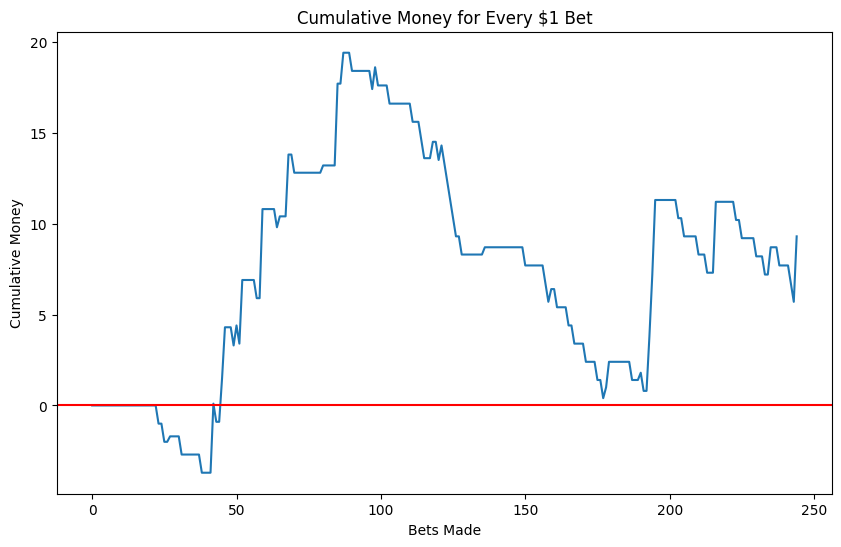

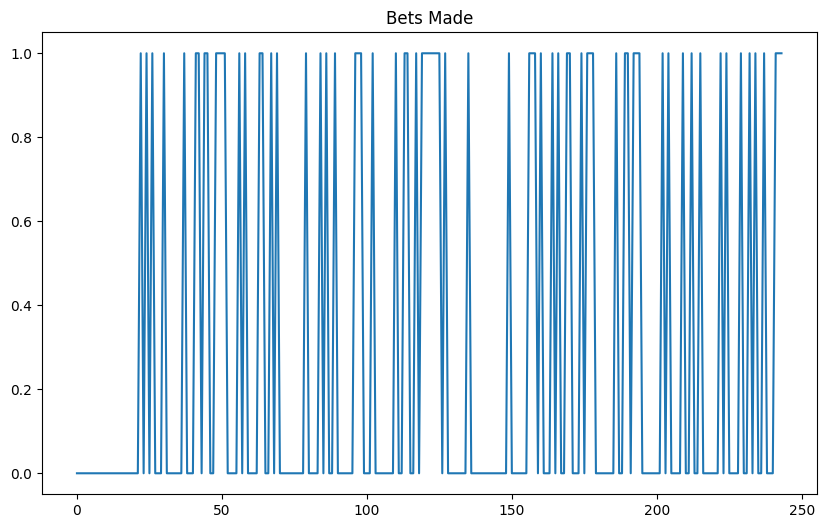

Final Money:  9.3
Total Bets Made:  73 

Random Forest Classifier


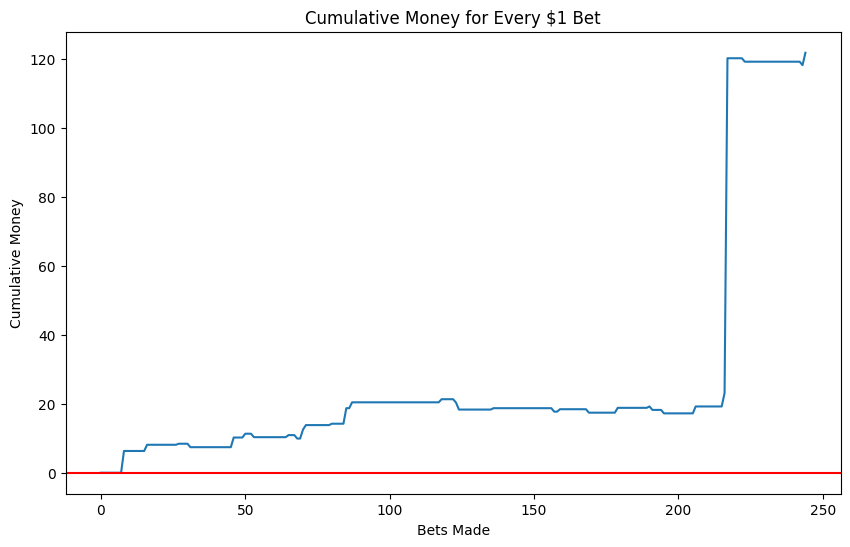

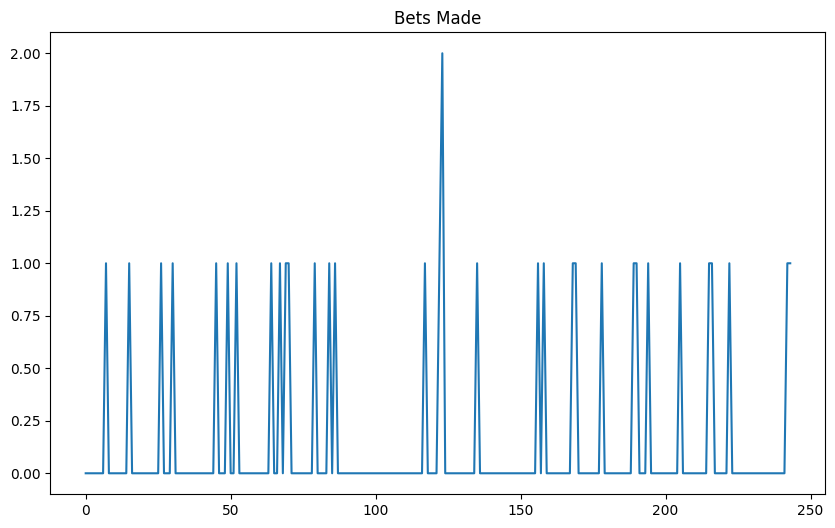

Final Money:  121.7
Total Bets Made:  33 

SMOTE + RF


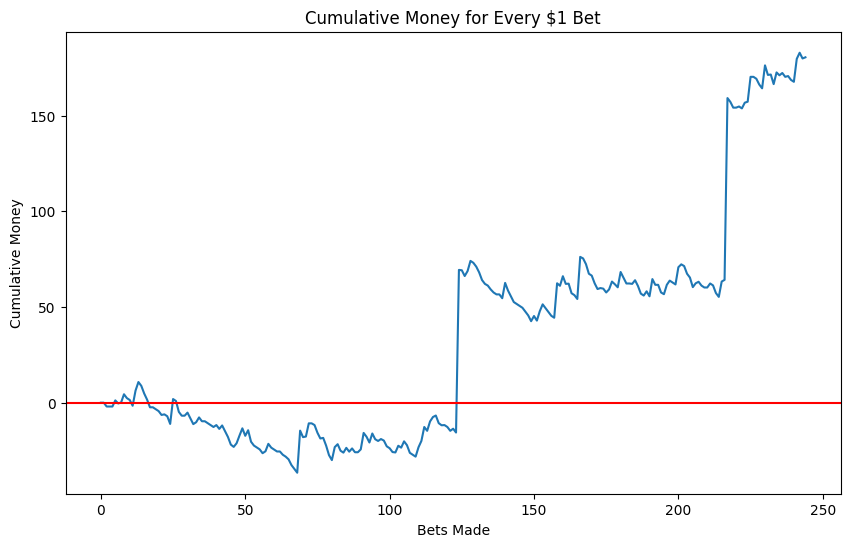

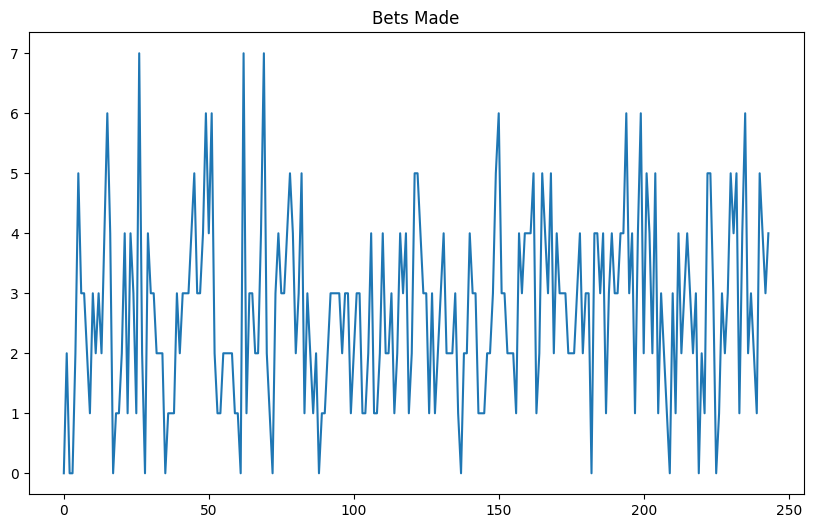

Final Money:  180.5
Total Bets Made:  657 



In [22]:
# Create a dataframe to store the results
strat1_results = pd.DataFrame(columns=['Model', 'Money', 'Bets Made'])

for model_name, class_model in class_pred_dict.items():

        # Print the model name
        print(model_name)

        # change False to True if you want to view the graph
        money, bets = simple_class_strategy(class_model, graph=True)

        # Append the results to the dataframe
        strat1_results.loc[len(strat1_results)] = [model_name, money, sum(bets)]

Ridge Regression


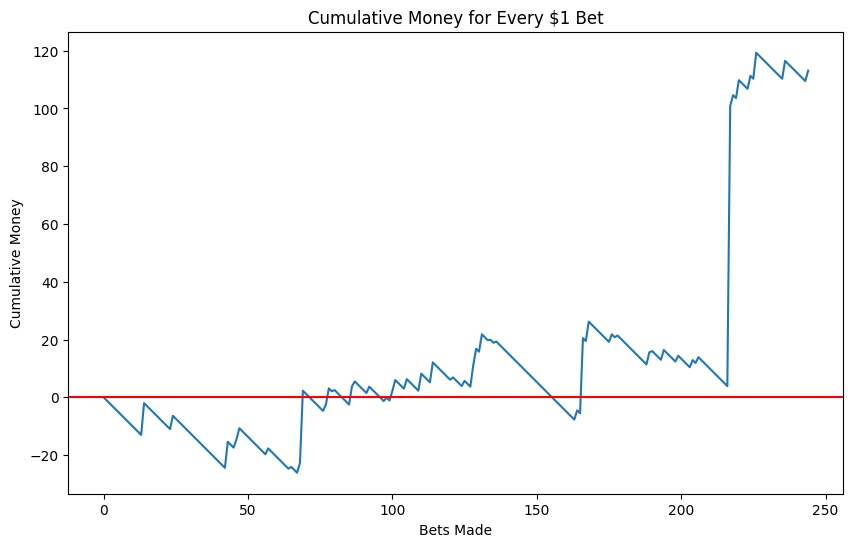

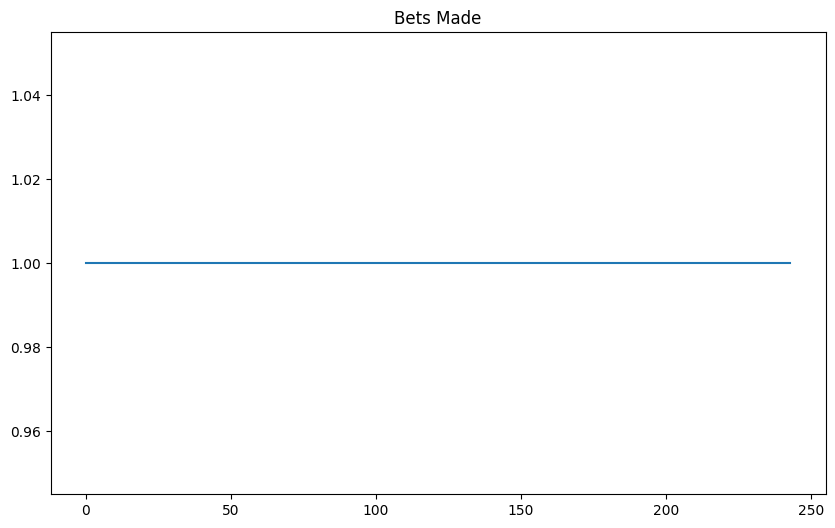

Final Money:  113.1
Total Bets Made:  244 

KNN Regression


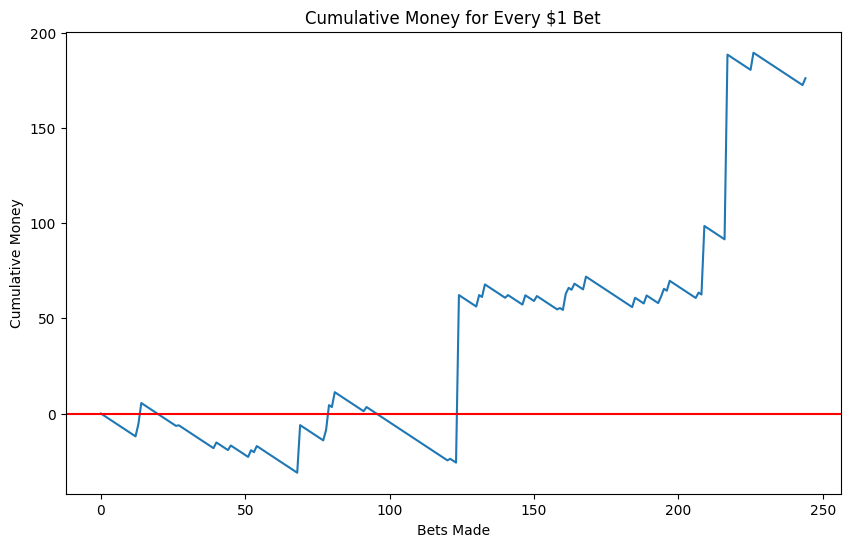

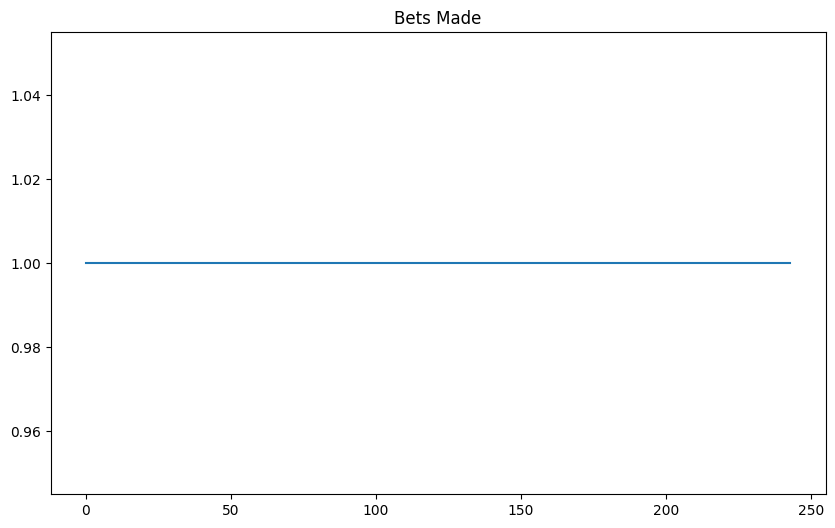

Final Money:  176.1
Total Bets Made:  244 

Random Forest Regressor


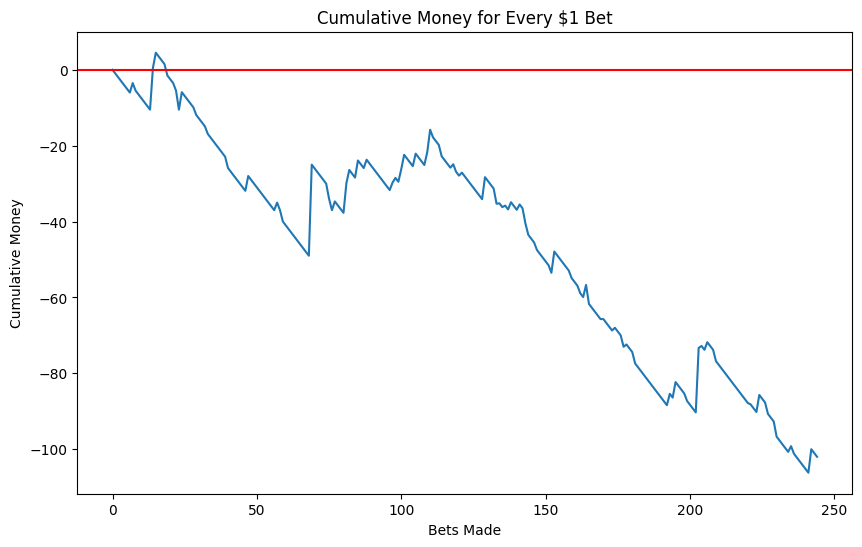

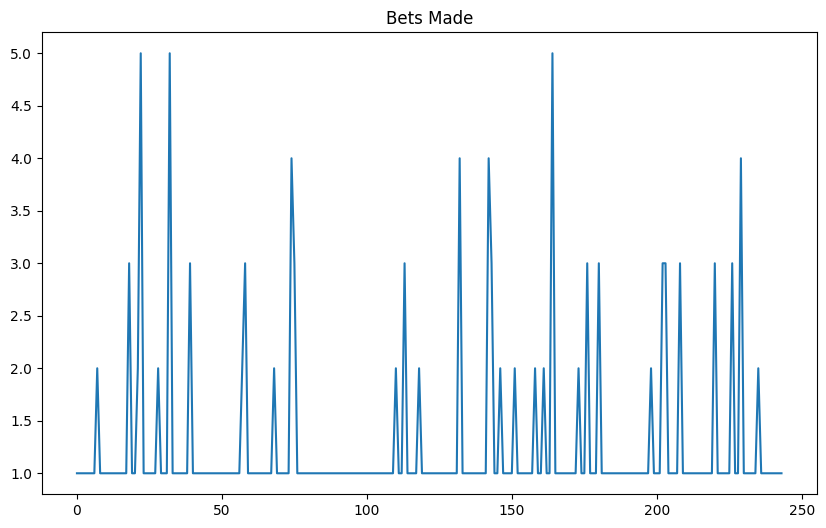

Final Money:  -102.0
Total Bets Made:  308 

LGBM


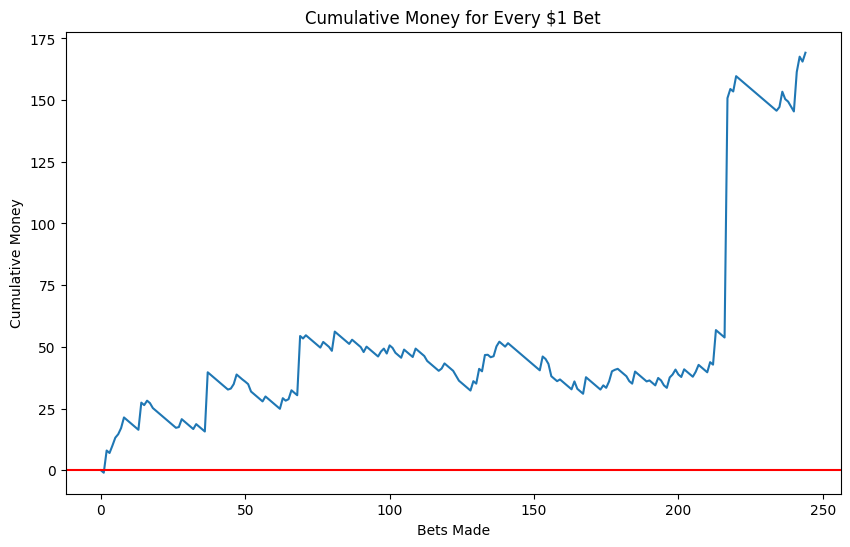

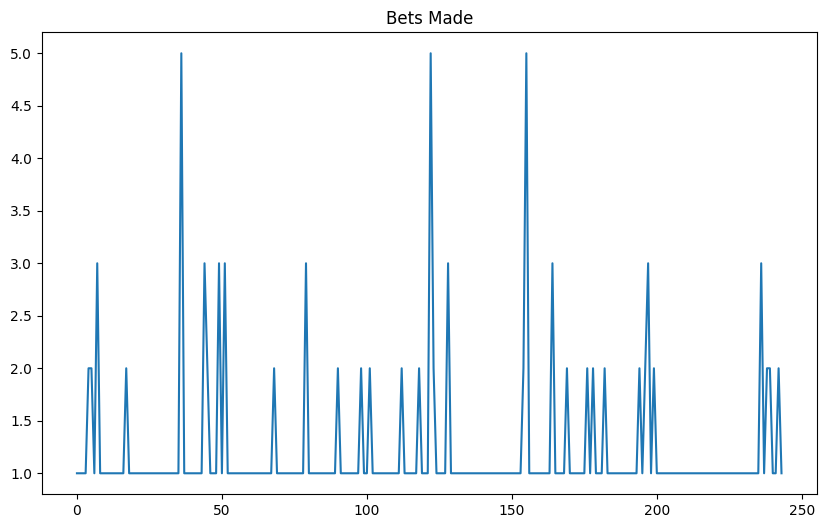

Final Money:  169.2
Total Bets Made:  296 



In [23]:
# Create a dataframe to store the results
strat2_results = pd.DataFrame(columns=['Model', 'Money', 'Bets Made'])

for model_name, reg_model in reg_pred_dict.items():

        # Print the model name
        print(model_name)

        # change False to True if you want to view the graph
        money, bets = simple_reg_strategy(reg_model, graph = True)

        # Append the results to the dataframe
        strat2_results.loc[len(strat2_results)] = [model_name, money, sum(bets)]

In [24]:
# Create a dataframe to store the results
strat3_results = pd.DataFrame(columns=['Model', 'Money', 'Bets Made'])

for model_name, class_model in class_pred_dict.items():

        # change False to True if you want to view the graph
        money, bets = top3_strategy(class_model, graph = False)

        # Append the results to the dataframe
        strat3_results.loc[len(strat3_results)] = [model_name, money, sum(bets)]

Final Money:  106.8
Total Bets Made:  248 

Final Money:  50.2
Total Bets Made:  427 

Final Money:  118.2
Total Bets Made:  260 

Final Money:  91.9
Total Bets Made:  1102 



In [25]:
# Create a dataframe to store the results
strat4_results = pd.DataFrame(columns=['Model', 'Money', 'Bets Made'])

for model_name1, model1 in class_pred_dict.items():
    for model_name2, model2 in reg_pred_dict.items():
        combo_model = model_name1, model_name2

        # Print the combo model name
        print(combo_model)

        # change False to True if you want to view the graph
        money, bets = hybrid_strategy(model1, model2, graph = False)

        # Append the results to the dataframe
        strat4_results.loc[len(strat4_results)] = [combo_model, money, sum(bets)]

('Logistic Regression', 'Ridge Regression')
Final Money:  10.0
Total Bets Made:  6 

('Logistic Regression', 'KNN Regression')
Final Money:  2.6
Total Bets Made:  5 

('Logistic Regression', 'Random Forest Regressor')
Final Money:  3.5
Total Bets Made:  4 

('Logistic Regression', 'LGBM')
Final Money:  8.9
Total Bets Made:  13 

('Gaussian Naive Bayes', 'Ridge Regression')
Final Money:  5.3
Total Bets Made:  26 

('Gaussian Naive Bayes', 'KNN Regression')
Final Money:  -2.2
Total Bets Made:  29 

('Gaussian Naive Bayes', 'Random Forest Regressor')
Final Money:  -1.0
Total Bets Made:  28 

('Gaussian Naive Bayes', 'LGBM')
Final Money:  -7.0
Total Bets Made:  48 

('Random Forest Classifier', 'Ridge Regression')
Final Money:  104.9
Total Bets Made:  13 

('Random Forest Classifier', 'KNN Regression')
Final Money:  95.6
Total Bets Made:  10 

('Random Forest Classifier', 'Random Forest Regressor')
Final Money:  4.8
Total Bets Made:  8 

('Random Forest Classifier', 'LGBM')
Final Money:  1

In [26]:
# Print Strategy 1 Results
strat1_results.sort_values(by='Money', ascending=False)

,Model,Money,Bets Made
3,SMOTE + RF,180.5,657
2,Random Forest Classifier,121.7,33
1,Gaussian Naive Bayes,9.3,73
0,Logistic Regression,8.9,13


In [27]:
# Print strategy 2 results
strat2_results.sort_values(by='Money', ascending=False)

,Model,Money,Bets Made
1,KNN Regression,176.1,244
3,LGBM,169.2,296
0,Ridge Regression,113.1,244
2,Random Forest Regressor,-102.0,308


In [28]:
# Print strategy 3 results
strat3_results.sort_values(by='Money', ascending=False)

,Model,Money,Bets Made
2,Random Forest Classifier,118.2,260
0,Logistic Regression,106.8,248
3,SMOTE + RF,91.9,1102
1,Gaussian Naive Bayes,50.2,427


In [29]:
# Print strategy 4 results
strat4_results.sort_values(by='Money', ascending=False)

,Model,Money,Bets Made
13,"(SMOTE + RF, KNN Regression)",202.8,72
15,"(SMOTE + RF, LGBM)",153.4,158
12,"(SMOTE + RF, Ridge Regression)",149.7,92
11,"(Random Forest Classifier, LGBM)",112.3,26
8,"(Random Forest Classifier, Ridge Regression)",104.9,13
9,"(Random Forest Classifier, KNN Regression)",95.6,10
0,"(Logistic Regression, Ridge Regression)",10.0,6
3,"(Logistic Regression, LGBM)",8.9,13
4,"(Gaussian Naive Bayes, Ridge Regression)",5.3,26
10,"(Random Forest Classifier, Random Forest Regre...",4.8,8
